# NIST PREP Summer 2020

- This is a summary of my accomplishments in the NIST PREP program
- Data was obtained from the Windover Group, NIST Gaithersburg

- loading standard Python packages and enabling plotting

In [73]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.patches import Ellipse
%matplotlib inline

- include custom gaussian for simple gaussian fits
- include custom bruker_io toolbox
- include custom Spectrum_Evaulation toolbox


In [74]:
import gaussian
import bruker_io as brio
import spectrum_evaluation as se


- import XRF data from a *.txt

In [75]:
Mo_acryl = brio.FittingData(os.path.join('Acrylic', '20170510_D1_Mo_50kv_100mA_acryl 0_python.txt'))
brio.bruker_txt_import(Mo_acryl)

import size:  (4096,)


- plot spectrum data from *.txt file

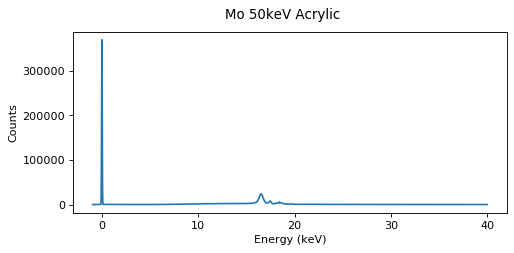

In [76]:
fig = plt.figure(num=None, figsize=(7, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Mo_acryl.energy_scale, Mo_acryl.channels)
fig.suptitle('Mo 50keV Acrylic')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

- import XRF data from a *.spx file

In [77]:
Ti = brio.FittingData(os.path.join('Trials', 'Element B Ti.spx'))
brio.bruker_spx_import(Ti)

- plot spectrum data from *.spx file

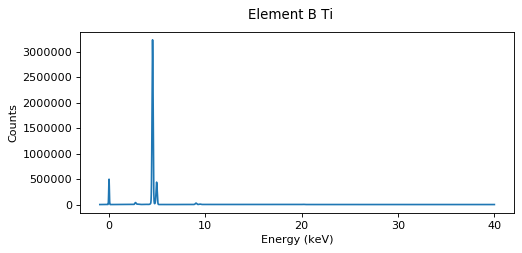

In [78]:
fig = plt.figure(num=None, figsize=(7, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Ti.energy_scale, Ti.channels)
fig.suptitle('Element B Ti')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

- fit a gaussian to a sample

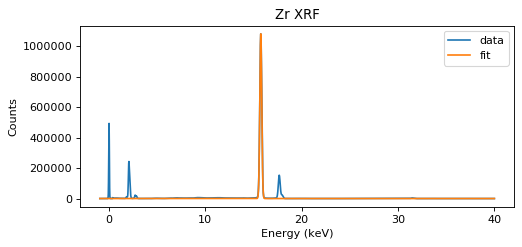

In [79]:
gaussian.element_b("Zr")

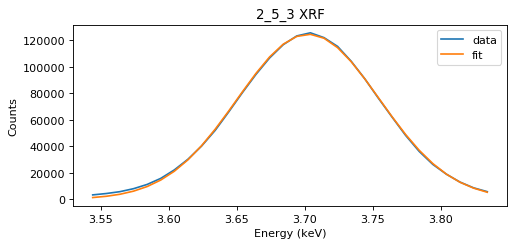

In [80]:
gaussian.glass("2_5_3", 450, 480)